In [1]:
import pandas as pd 
import numpy as np
import hashlib
import math
from csv import reader
import re
import os
import altair as alt
# import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
import re
pd.set_option('display.max_rows', None)
plt.style.use('seaborn-v0_8-dark-palette')


In [2]:
def hash_str(to_hash): 
    stringToHash = to_hash.encode()
    return hashlib.sha256(stringToHash).hexdigest()

In [3]:
def process_lbl(line_list, filename): 
    data_list = []
    i = 0
    name_line = ''
    
    if 'cfg' in filename: 
        setup = 'cfg'
    elif 'risc0' in filename: 
        setup = 'risc0'
    elif 'coral' in filename: 
        setup = 'coral'
    else: 
        setup = 'unknown' 

        
    if 'json' in filename: 
        app = 'json'
    elif 'toml' in filename:
        app = 'toml'
    elif filename[0]=='c': 
        app = 'c'
    else: 
        app = 'unknown'

    doc_name = (filename.split('/')[-1])[:-4]
        
    while (i < len(line_list)): 
        if i+1 < len(line_list) and '---------,---------,---------,---------' in line_list[i+1]:
            name_line = line_list[i].strip('\n')     
        elif "---------,---------,---------,---------" in line_list[i]: 
            pass
        else:   
            for line in reader([setup+','+app+','+name_line+','+line_list[i].strip()]):
                if setup=='coral':
                    to_append = [doc_name]+line[:2]+line[4:]
                else: 
                    to_append = [doc_name]+line[:2]+[line[4]]+[0,0]+[line[5]]+ line[5:] 
                if len(to_append)!= 13: 
                    print(to_append)
                data_list.append(to_append)
        i = i + 1
    return data_list        

In [4]:
def process_mem(line_list, filename): 
    data_list = []
    i = 0
    name_line = ''
    setup = ''
    app = ''
    doc = ''
    regex = ''
    batch_size = 0

    if 'cfg' in filename: 
        setup = 'cfg'
    elif 'risc0' in filename: 
        setup = 'risc0'
    elif 'coral' in filename: 
        setup = 'coral'
    else: 
        setup = 'unknown' 

    while (i < len(line_list)): 
        if 'Command being timed:' in line_list[i]:
            name_line = line_list[i]

            if 'json' in filename: 
                app = 'json'
            elif 'toml' in filename:
                app = 'toml'
            elif 'c_' in filename:
                app = 'c'
            else: 
                app = 'unknown'

            doc_size = filename.split('_')[1]

            if setup == 'coral': 
                batch_size = re.findall("-b ([0-9]*)", name_line)[0]
            else: 
                bacth_size = doc_size

        elif "Maximum resident set size" in line_list[i]: 
            mem_usage = int(line_list[i].split(':')[1].strip())/1e3
            data_list.append([filename, app, setup, doc_size, batch_size, mem_usage])
        else: 
           pass
        i = i + 1
    return data_list     

In [5]:
time_data = []
time_directory = 'tests/results/timings/scale'
 
# iterate over files in
# that directory
for filename in os.listdir(time_directory):
    filepath = os.path.join(time_directory, filename)
    if 'Data' not in filename and 'DS_Store' not in filename and os.path.isfile(filepath):
        print(filepath)
        f = open(filepath, "r")
        lbl = [x for x in f]
        f.close()
        time_data.extend(process_lbl(lbl,filename))

tests/results/timings/scale/json_4096_risc0_cfg.txt
tests/results/timings/scale/json_32768_coral.txt
tests/results/timings/scale/json_128_risc0_cfg.txt
tests/results/timings/scale/json_8192_coral.txt
tests/results/timings/scale/json_64_risc0_cfg.txt
tests/results/timings/scale/json_2048_risc0_json.txt
tests/results/timings/scale/json_16384_coral.txt
tests/results/timings/scale/json_8192_risc0_json.txt
tests/results/timings/scale/json_1024_risc0_json.txt
tests/results/timings/scale/json_256_risc0_json.txt
tests/results/timings/scale/json_16384_risc0_json.txt
tests/results/timings/scale/json_64_risc0_json.txt
tests/results/timings/scale/json_256_coral.txt
tests/results/timings/scale/json_4096_coral.txt
tests/results/timings/scale/json_512_risc0_json.txt
tests/results/timings/scale/json_2048_coral.txt
tests/results/timings/scale/json_128_risc0_json.txt
tests/results/timings/scale/json_32768_risc0_json.txt
tests/results/timings/scale/json_512_coral.txt
tests/results/timings/scale/json_128_

In [40]:
time_df = pd.DataFrame(time_data, columns = ['doc_name','setup','app','time','n_rules','tree_size','doc_len','batch_size',
                                    'test_type','component','test','val','metric'])
num_cols = ['n_rules','tree_size','batch_size','val','doc_len']
time_df[num_cols] = time_df[num_cols].apply(pd.to_numeric,errors='coerce', axis=1)

In [41]:
e2e = time_df.loc[time_df.test.str.contains('prove_e2e')].reset_index()
e2e_coral = time_df.loc[time_df.test.str.contains('prove_e2e')].groupby(['time','setup','app','doc_len','batch_size']).val.sum().reset_index()
df_e2e_avg = e2e_coral.groupby(['setup','app','batch_size','doc_len']).val.mean().reset_index()

e2e_avg_small = df_e2e_avg.iloc[df_e2e_avg.groupby('doc_len')["val"].nsmallest(1).index.get_level_values(1)].sort_values(by='doc_len')
e2e_nc = time_df.loc[(time_df.setup!='coral') & (time_df.test=='prove')]
df_e2e_nc_avg = e2e_nc.groupby(['setup','app','doc_len']).val.mean().reset_index().sort_values(by='doc_len')

In [42]:
mem_data_coral = []
mem_directory = 'tests/results/memory/scale'
 
for filename in os.listdir(mem_directory):
    filepath = os.path.join(mem_directory, filename)
    if 'Data' not in filename and 'DS_Store' not in filename and os.path.isfile(filepath):
        print(filepath)
        f = open(filepath, "r")
        lbl = [x for x in f]
        f.close()
        mem_data_coral.extend(process_mem(lbl,filename))
        
# mem_df = pd.DataFrame(mem_data_coral)
mem_df = pd.DataFrame(mem_data_coral, columns = ['filename','app','setup','doc_len','batch_size','val'])
num_cols = ['val','doc_len','batch_size']
mem_df[num_cols] = mem_df[num_cols].apply(pd.to_numeric,errors='coerce', axis=1)

tests/results/memory/scale/json_65536_risc0_json
tests/results/memory/scale/json_16384_coral
tests/results/memory/scale/json_4096_risc0_cfg
tests/results/memory/scale/json_256_risc0_cfg
tests/results/memory/scale/json_1024_coral
tests/results/memory/scale/json_4096_coral
tests/results/memory/scale/json_1024_risc0_json
tests/results/memory/scale/json_128_coral
tests/results/memory/scale/json_2048_coral
tests/results/memory/scale/json_8192_risc0_json
tests/results/memory/scale/json_4096_risc0_json
tests/results/memory/scale/json_128_risc0_json
tests/results/memory/scale/json_8192_coral
tests/results/memory/scale/json_256_coral
tests/results/memory/scale/json_32768_coral
tests/results/memory/scale/json_64_coral
tests/results/memory/scale/json_32768_risc0_json
tests/results/memory/scale/json_512_risc0_json
tests/results/memory/scale/json_16384_risc0_json
tests/results/memory/scale/json_256_risc0_json
tests/results/memory/scale/json_512_coral
tests/results/memory/scale/json_1024_risc0_cfg
t

In [43]:
mem_df_avg = mem_df.groupby(['filename','setup','app','doc_len','batch_size']).val.mean().reset_index()
mem_coral = mem_df_avg.loc[mem_df_avg.setup.str.contains("coral")]

In [44]:
best_prove_time_combo = list(zip(e2e_avg_small.doc_len, e2e_avg_small.batch_size))
tuples_in_df = pd.MultiIndex.from_frame(mem_coral[["doc_len","batch_size"]])
mem_coral_small = mem_coral[tuples_in_df.isin(best_prove_time_combo)].sort_values(by=['doc_len'])

In [45]:
mem_nc = mem_df_avg.loc[mem_df_avg.setup != "coral"].sort_values(by=['doc_len'])

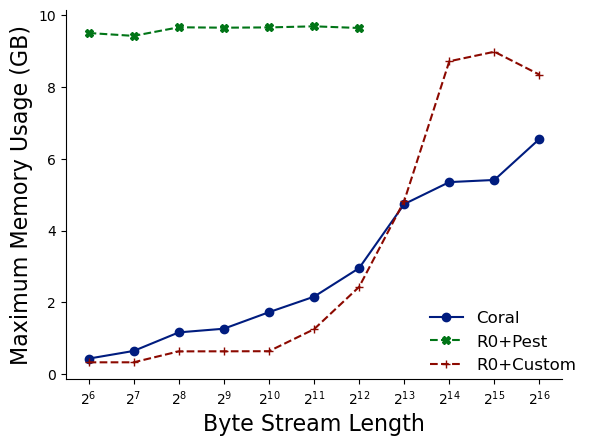

In [50]:
# Create a figure and an axes
# plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
ax.set_xscale('log', base = 2)
# ax.set_yscale('log')

# Group data by the 'line_id' column
# for line_name, group_data in df.groupby('line_id'):
#     Plot x_value vs y_value for each group
ax.plot(mem_coral_small.doc_len, mem_coral_small.val/1e3, marker='o')


i = 0; 
for line_name, group_data in mem_nc.groupby('setup'):
    if i == 0: 
        ax.plot(group_data.doc_len, group_data.val/1e3, linestyle='dashed', marker='X')
        i = i + 1
    else:
        ax.plot(group_data.doc_len, group_data.val/1e3, linestyle='dashed', marker='+')

# Add labels and title
ax.set_xlabel("Byte Stream Length", fontsize=16)
ax.set_ylabel("Maximum Memory Usage (GB)", fontsize=16)
ax.set_xticks([2**i for i in range(6,17)])
ax.set_facecolor('white')
# ax.set_title("Maximum Memory Usage")

# Add a legend to distinguish lines
# ax.legend()
ax.legend(['Coral', 'R0+Pest', 'R0+Custom'], loc=(.72,0), fontsize=12, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display the plot
plt.savefig("compmem.pdf", format="pdf",bbox_inches='tight' )
plt.show()

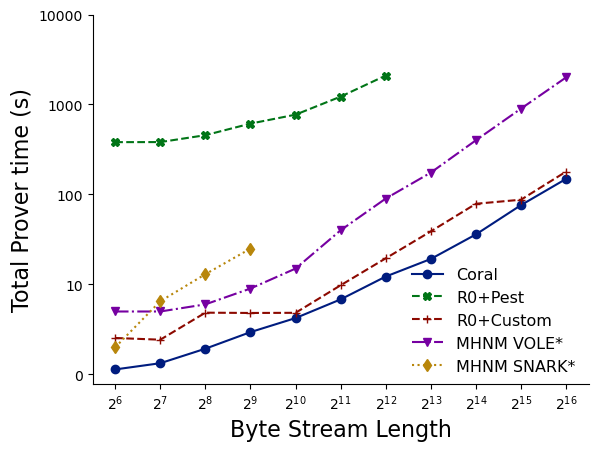

In [51]:
# Create a figure and an axes
fig, ax = plt.subplots()
# plt.rcParams.update({'font.size': 15})
ax.set_xscale('log', base = 2)
ax.set_yscale('log')

# Group data by the 'line_id' column
# for line_name, group_data in df.groupby('line_id'):
    # Plot x_value vs y_value for each group
ax.plot(e2e_avg_small.doc_len, e2e_avg_small.val/1e6, marker='o')

i = 0
for line_name, group_data in df_e2e_nc_avg.groupby('setup'):
    if i == 0: 
        m = 'X'
        i = i + 1
    else: 
        m = '+'
    ax.plot(group_data.doc_len, group_data.val/1e6, linestyle='dashed', marker=m)

ax.plot([2**i for i in range(6,17)],[5,5,6,9,15,40,90,175,400,900,2000], linestyle='dashdot',marker='v')
ax.plot([2**i for i in range(6,10)],[2,6.5,13,25],linestyle='dotted',marker="d")

# Add labels and title
ax.set_xlabel("Byte Stream Length",fontsize=16)
ax.set_ylabel("Total Prover time (s)",fontsize=16)
ax.set_xticks([2**i for i in range(6,17)])
ax.set_yticks([1,10,100])
plt.yticks([1,10,100,1000,10000], ['0','10','100','1000','10000'])
ax.set_facecolor('white')
# ax.set_title("Prover time as a function of Document Size")
plt.minorticks_off()

# Add a legend to distinguish lines
ax.legend(['Coral', 'R0+Pest', 'R0+Custom','MHNM VOLE*', 'MHNM SNARK*'], prop={'size': 11.5}, loc=(.63,.01), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#Change to be shapes, and change colors, maybe fix log scale idk 
# Display the plot
plt.savefig("comptime.pdf", format="pdf",bbox_inches='tight')
plt.show()

In [49]:
app_data = []
app_directory = 'tests/results/timings/apps'
 
# iterate over files in
# that directory
for filename in os.listdir(app_directory):
    filepath = os.path.join(app_directory, filename)
    if 'Data' not in filename and 'DS_Store' not in filename and os.path.isfile(filepath):
        print(filepath)
        f = open(filepath, "r")
        lbl = [x for x in f]
        f.close()
        app_data.extend(process_lbl(lbl,filename))

tests/results/timings/apps/c_c1_risc0_c.txt
tests/results/timings/apps/json_jwt_coral.txt
tests/results/timings/apps/c_c3_coral.txt
tests/results/timings/apps/json_bank_citi_risc0_cfg.txt
tests/results/timings/apps/json_hibp_small_coral.txt
tests/results/timings/apps/toml_ark_coral.txt
tests/results/timings/apps/json_bank_plaid_coral.txt
tests/results/timings/apps/c_llvm_risc0_c.txt
tests/results/timings/apps/json_bank_plaid_risc0_json.txt
tests/results/timings/apps/c_llvm_risc0_cfg.txt
tests/results/timings/apps/json_bank_citi_coral.txt
tests/results/timings/apps/toml_coral_risc0_toml.txt
tests/results/timings/apps/c_c2_risc0_cfg.txt
tests/results/timings/apps/json_hibp_coral.txt
tests/results/timings/apps/c_c1_risc0_cfg.txt
tests/results/timings/apps/c_c2_coral.txt
tests/results/timings/apps/json_bank_citi_risc0_json.txt
tests/results/timings/apps/c_llvm_coral.txt
tests/results/timings/apps/c_c2_risc0_c.txt
tests/results/timings/apps/json_hibp_small_risc0_json.txt
tests/results/timin

In [17]:
mem_app_data_coral = []
mem_app_directory = 'tests/results/memory/apps'
 
for filename in os.listdir(mem_app_directory):
    filepath = os.path.join(mem_app_directory, filename)
    if 'Data' not in filename and 'DS_Store' not in filename and os.path.isfile(filepath):
        print(filepath)
        f = open(filepath, "r")
        lbl = [x for x in f]
        f.close()
        mem_app_data_coral.extend(process_mem(lbl,filename))
        
# mem_df = pd.DataFrame(mem_data_coral)
mem_app_df = pd.DataFrame(mem_app_data_coral, columns = ['filename','app','setup','doc_name','batch_size','val'])
num_cols = ['val','batch_size']
mem_app_df[num_cols] = mem_app_df[num_cols].apply(pd.to_numeric,errors='coerce', axis=1)

tests/results/memory/apps/c_c1_risc0_c
tests/results/memory/apps/json_jwt_risc0_json
tests/results/memory/apps/json_hibp_small_risc0_json
tests/results/memory/apps/c_c2_risc0_cfg
tests/results/memory/apps/json_bank_citi_risc0_json
tests/results/memory/apps/toml_ark_coral
tests/results/memory/apps/c_llvm_risc0_c
tests/results/memory/apps/json_hibp_risc0_json
tests/results/memory/apps/json_jwt_coral
tests/results/memory/apps/json_bank_citi_risc0_cfg
tests/results/memory/apps/json_hibp_risc0_cfg
tests/results/memory/apps/toml_ark_risc0_toml
tests/results/memory/apps/json_dk_risc0_json
tests/results/memory/apps/toml_coral_coral
tests/results/memory/apps/json_hibp_small_risc0_cfg
tests/results/memory/apps/json_dmv_veratad_coral
tests/results/memory/apps/toml_coral_risc0_toml
tests/results/memory/apps/toml_small_coral
tests/results/memory/apps/c_c2_risc0_c
tests/results/memory/apps/toml_ark_risc0_cfg
tests/results/memory/apps/json_bank_plaid_risc0_cfg
tests/results/memory/apps/c_c3_risc0_c
t

In [18]:
mem_app_df_avg = mem_app_df.groupby(['filename','setup','app','doc_name','batch_size']).val.mean().reset_index()
mem_app_coral = mem_app_df_avg.loc[mem_app_df_avg.setup.str.contains("coral")]

In [19]:
app_df = pd.DataFrame(app_data, columns = ['doc_name','setup','app','time','n_rules','tree_size','doc_len','batch_size',
                                    'test_type','component','test','val','metric'])
num_cols = ['n_rules','tree_size','batch_size','val','doc_len']
app_df[num_cols] = app_df[num_cols].apply(pd.to_numeric,errors='coerce', axis=1)

coral_app_df = app_df.loc[app_df.setup=='coral']


e2e_coral_app = coral_app_df.loc[coral_app_df.test.str.contains('prove_e2e')].groupby(['time',
                                                'app','doc_name','batch_size']).val.sum().reset_index()
df_e2e_avg_app = e2e_coral_app.groupby(['doc_name','app','batch_size']).val.mean().reset_index()
e2e_avg_small_app = df_e2e_avg_app.iloc[
    df_e2e_avg_app.groupby('doc_name')["val"].nsmallest(1).index.get_level_values(1)].sort_values(by='doc_name')

best_prove_time_combo_app = list(zip(e2e_avg_small_app.doc_name, e2e_avg_small_app.batch_size))
tuples_in_df_app = pd.MultiIndex.from_frame(coral_app_df[["doc_name","batch_size"]])
coral_df_app_filter = coral_app_df[tuples_in_df_app.isin(best_prove_time_combo_app)]

In [20]:
cfg = app_df.loc[(app_df.setup=='cfg')&(app_df.test=='prove')]
risc0 = app_df.loc[(app_df.setup=='risc0')&(app_df.test=='prove')]
risc0_avg = risc0.groupby(['doc_name','app','test']).val.mean().reset_index()
cfg_avg = cfg.groupby(['doc_name','app','test']).val.mean().reset_index()

In [21]:
coral_df_app_filter.loc[coral_df_app_filter.metric=='constraints'].groupby(['doc_name']).val.mean()

doc_name
c_c1_coral                 71546.0
c_c2_coral                123119.0
c_c3_coral                204011.0
c_llvm_coral              371929.0
json_bank_citi_coral      411732.0
json_bank_plaid_coral     111876.0
json_dk_coral             388297.0
json_dmv_veratad_coral    162280.0
json_hibp_coral           896738.0
json_hibp_small_coral     106133.0
json_jwt_coral            112115.0
toml_ark_coral            406197.0
toml_coral_coral          421269.0
toml_small_coral          200930.0
Name: val, dtype: float64

In [22]:
tuples_in_df_app_mem = pd.MultiIndex.from_frame(mem_app_coral[["filename","batch_size"]])
mem_app_coral[tuples_in_df_app_mem.isin(best_prove_time_combo_app)]

,filename,setup,app,doc_name,batch_size,val
6,c_c1_coral,coral,c,c1,87.0,604.528000
13,c_c2_coral,coral,c,c2,177.0,1003.057455
18,c_c3_coral,coral,c,c3,311.0,1302.165818
21,c_llvm_coral,coral,c,llvm,589.0,2052.240000
31,json_bank_citi_coral,coral,json,bank,814.0,2183.981091
40,json_bank_plaid_coral,coral,json,bank,201.0,971.780364
46,json_dk_coral,coral,json,dk,769.0,2142.394182
52,json_dmv_veratad_coral,coral,json,dmv,305.0,1210.464000
58,json_hibp_coral,coral,json,hibp,1806.0,5249.364571
75,json_jwt_coral,coral,json,jwt,201.0,983.581091


In [23]:
coral_df_app_filter.loc[coral_df_app_filter.metric=='bytes'].groupby(['doc_name']).val.mean()/1e3

doc_name
c_c1_coral                16.650
c_c2_coral                17.194
c_c3_coral                17.194
c_llvm_coral              17.738
json_bank_citi_coral      17.738
json_bank_plaid_coral     17.194
json_dk_coral             17.738
json_dmv_veratad_coral    17.194
json_hibp_coral           18.826
json_hibp_small_coral     16.650
json_jwt_coral            17.194
toml_ark_coral            17.738
toml_coral_coral          17.738
toml_small_coral          17.194
Name: val, dtype: float64

In [24]:
coral_df_app_filter.loc[(coral_df_app_filter.component=='V') & 
    (coral_df_app_filter.test.isin(["full_verify"]))].groupby(['doc_name',
                                                                    'time']).val.sum().reset_index().groupby(['doc_name']).val.mean()/1e6

doc_name
c_c1_coral                0.140109
c_c2_coral                0.149463
c_c3_coral                0.150902
c_llvm_coral              0.165779
json_bank_citi_coral      0.161927
json_bank_plaid_coral     0.149979
json_dk_coral             0.161774
json_dmv_veratad_coral    0.149642
json_hibp_coral           0.234923
json_hibp_small_coral     0.144944
json_jwt_coral            0.151169
toml_ark_coral            0.162605
toml_coral_coral          0.163826
toml_small_coral          0.152297
Name: val, dtype: float64

In [25]:
cg = coral_df_app_filter.loc[(
    (coral_df_app_filter.component=='CG') | 
    (coral_df_app_filter.test=='witness_synthesis0') |  
    (coral_df_app_filter.test.str.contains('nova_pp_gen'))
    ) & ((coral_df_app_filter.test!='doc') & (coral_df_app_filter.test!='ic'))]
cg.groupby(['time','doc_name']).val.sum().reset_index().groupby(['doc_name']).val.mean()/1e6

doc_name
c_c1_coral                1.797563
c_c2_coral                2.025506
c_c3_coral                2.236768
c_llvm_coral              2.855586
json_bank_citi_coral      2.914573
json_bank_plaid_coral     2.002659
json_dk_coral             2.854875
json_dmv_veratad_coral    2.124061
json_hibp_coral           4.956294
json_hibp_small_coral     1.946671
json_jwt_coral            2.029671
toml_ark_coral            2.916675
toml_coral_coral          2.962508
toml_small_coral          2.231403
Name: val, dtype: float64

In [26]:
coral_df_app_filter.loc[coral_df_app_filter.test=='e2e_solving'].groupby(['doc_name']).val.mean()/1e6

doc_name
c_c1_coral                0.229683
c_c2_coral                0.247411
c_c3_coral                0.263912
c_llvm_coral              0.362934
json_bank_citi_coral      0.417768
json_bank_plaid_coral     0.247064
json_dk_coral             0.364484
json_dmv_veratad_coral    0.268589
json_hibp_coral           2.755082
json_hibp_small_coral     0.244175
json_jwt_coral            0.253362
toml_ark_coral            0.594410
toml_coral_coral          0.537453
toml_small_coral          0.261408
Name: val, dtype: float64

In [27]:
coral_df_app_filter.loc[coral_df_app_filter.test=='prove_e2e'].groupby(['doc_name']).val.mean()/1e6

doc_name
c_c1_coral                 1.225598
c_c2_coral                 2.400593
c_c3_coral                 3.116069
c_llvm_coral               6.850846
json_bank_citi_coral       7.915372
json_bank_plaid_coral      2.407680
json_dk_coral              6.487227
json_dmv_veratad_coral     3.356914
json_hibp_coral           31.812018
json_hibp_small_coral      2.000916
json_jwt_coral             2.857102
toml_ark_coral            11.482634
toml_coral_coral          10.291806
toml_small_coral           2.890030
Name: val, dtype: float64

In [28]:
def change_app_name_json(filename): 
    if "citi" in filename: 
        return "CitiBank"
    if "plaid" in filename: 
        return "Plaid"
    if "dk" in filename: 
        return "Sports"
    if "dmv" in filename: 
        return "Age"
    if "hibp_small" in filename: 
        return "HIBP"
    if "hibp" in filename: 
        return "X"
    if "jwt" in filename: 
        return "JWT"
    else: 
        return "Unknown"
        
def change_app_name(filename): 
    if "c1" in filename: 
        return "C1"
    if "c2" in filename: 
        return "C2"
    if "c3" in filename: 
        return "C3"
    if "llvm" in filename: 
        return "LLVM"
    if "toml_small" in filename: 
        return "T1"
    if "toml_coral" in filename: 
        return "T2"
    if "ark" in filename: 
        return "T3"
    else: 
        return "Unknown"
  
def change_test_name(test): 
    if test=="prove": 
        return "Baseline"
    if test=="Solving":
        return "Solving"
    if test=="prove_e2e":
        return "Prove"
    if test=="solving":
        return "Solving"
    else: 
        return "Unknown"

In [55]:
pt_coral = coral_df_app_filter.loc[coral_df_app_filter.test.str.contains('prove_e2e')].groupby([
                                                'app','doc_name','batch_size','test']).val.mean().reset_index()
pt_coral_solving_int = coral_df_app_filter.loc[coral_df_app_filter.test.str.contains('e2e_solving')].groupby([
                                                'app','doc_name','batch_size','time']).val.sum().reset_index()
pt_coral_solving = pt_coral_solving_int.groupby([
                                                'app','doc_name','batch_size']).val.mean().reset_index()
pt_coral_solving['test']='Solving'

pt_coral = pd.concat([pt_coral, pt_coral_solving])
json_coral = pt_coral.loc[pt_coral.app=='json']
json_cfg = cfg_avg.loc[cfg_avg.app=='json']
json_risc0 = risc0_avg.loc[risc0_avg.app=='json']

In [56]:
json_coral['Name'] = json_coral.doc_name.apply(lambda x: change_app_name_json(x))
json_cfg['Name'] = json_cfg.doc_name.apply(lambda x: change_app_name_json(x))
json_risc0['Name'] = json_risc0.doc_name.apply(lambda x: change_app_name_json(x))

json_coral['Component'] = json_coral.test.apply(lambda x: change_test_name(x))
json_cfg['Component'] = json_cfg.test.apply(lambda x: change_test_name(x))
json_risc0['Component'] = json_risc0.test.apply(lambda x: change_test_name(x))

/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2390281631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_coral['Name'] = json_coral.doc_name.apply(lambda x: change_app_name_json(x))
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2390281631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_cfg['Name'] = json_cfg.doc_name.apply(lambda x: change_app_name_json(x))
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2390281631.py:3: SettingWithCop

In [57]:
def prep_df(df, name):
    # df = df.stack().reset_index()
    df.columns = ['val', 'Name', 'Component']
    df.val = df.val/1e6
    df['Setup'] = name
    return df


In [58]:
df1 = prep_df(json_coral[['val', 'Name', 'Component']], 'Coral')
df2 = prep_df(json_cfg[['val', 'Name', 'Component']], 'R0+Pest')
df3 = prep_df(json_risc0[['val', 'Name', 'Component']], 'R0+Custom')

df = pd.concat([df1, df2, df3])

/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.val = df.val/1e6
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Setup'] = name
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [59]:
df = df.loc[df.Name!='X']
custom = {'Age':0, "CitiBank":1, "Plaid":2, "Sports":3, "HIBP":4, "JWT":5}
df = df.sort_values(by=['Name'],key=lambda x: x.map(custom))

In [63]:
 # chart = 
c1 = alt.Chart(df).mark_bar(clip=True).encode(

    # tell Altair which field to group columns on
    x=alt.X('Setup:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(val):Q',
        axis=alt.Axis(
            grid=False,
            title="Total Prover Time")).scale(domain=(0,60)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Name:N', title=None,header=alt.Header(titleOrient='bottom', labelOrient='bottom',labelFontSize=15)).sort(['sadf']),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'val',
      sort='descending'
    ),
    # tell Altair which field to use for color segmentation 
    color=alt.Color('Component:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#3d85c6', '#FF7F50','#b43709',"#d74814"],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).configure_axis(
    labelFontSize=15,
    titleFontSize=15
).configure_legend(
     titleFontSize=15,
    labelFontSize=15,
    padding = 1,
    fillColor='white',
    orient = 'none', 
    legendX = 10,
    legendY = 40,
).properties(
    width=100,
    height=300
)
c1.save("json_comp.pdf")

ValueError: Saving charts in 'pdf' format requires the vl-convert-python package: see https://altair-viz.github.io/user_guide/saving_charts.html#png-svg-and-pdf-format

In [64]:
c1

alt.Chart(...)

In [65]:
# pt_coral = coral_df_filter.loc[coral_df_filter.test.str.contains('e2e|solving|sample')].groupby([
#                                                 'app','doc_name','batch_size','test']).val.mean().reset_index()
app_coral = pt_coral.loc[pt_coral.app!='json']
app_cfg = cfg_avg.loc[cfg_avg.app!='json']
app_risc0 = risc0_avg.loc[risc0_avg.app!='json']

In [66]:
app_coral['Name'] = app_coral.doc_name.apply(lambda x: change_app_name(x))
app_cfg['Name'] = app_cfg.doc_name.apply(lambda x: change_app_name(x))
app_risc0['Name'] = app_risc0.doc_name.apply(lambda x: change_app_name(x))

app_coral['Component'] = app_coral.test.apply(lambda x: change_test_name(x))
app_cfg['Component'] = app_cfg.test.apply(lambda x: change_test_name(x))
app_risc0['Component'] = app_risc0.test.apply(lambda x: change_test_name(x))

/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2585962810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_coral['Name'] = app_coral.doc_name.apply(lambda x: change_app_name(x))
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2585962810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_cfg['Name'] = app_cfg.doc_name.apply(lambda x: change_app_name(x))
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2585962810.py:3: SettingWithCopyWarning: 
A v

In [67]:
df1 = prep_df(app_coral[['val', 'Name', 'Component']], 'Coral')
df2 = prep_df(app_cfg[['val', 'Name', 'Component']], 'R0+Pest')
df3 = prep_df(app_risc0[['val', 'Name', 'Component']], 'R0+Custom')

df = pd.concat([df1, df2, df3])
df = df.sort_values(by='Name', ascending = True)

/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.val = df.val/1e6
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Setup'] = name
/var/folders/y0/m5s5d3c1733_n9v6lmsxn3v00000gn/T/ipykernel_63919/2225007191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [68]:
# chart = 
alt.Chart(df).mark_bar(clip=True).encode(

    # tell Altair which field to group columns on
    x=alt.X('Setup:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(val):Q',
        axis=alt.Axis(
            grid=False,
            title="Total Prover Time")).scale(domain=(0,100)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('Name:N', title=None, sort=['C2','C1','C3','LLVM', 'T1','T2','T3'],
                     header=alt.Header(titleFontSize=200, titleOrient='bottom', labelOrient='bottom',labelFontSize=15)),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'val',
      sort='descending'
    ),
    # tell Altair which field to use for color segmentation 
    color=alt.Color('Component:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#3d85c6', '#FF7F50','#b43709',"#d74814"],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    ).configure_axis(
    labelFontSize=15,
    titleFontSize=15
).configure_legend(
     titleFontSize=15,
    labelFontSize=15,
            fillColor='white',
    orient = 'none', 
    legendX = 10,
    legendY = 40,
).properties(
    width=100,
    height=300
)
# chart.save("app_comp.pdf")

alt.Chart(...)